In [17]:
from __future__ import print_function, division
from astropy.io import fits
from astropy.table import Table, Column
import ccdproc
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


from graphing_functions import *

# "Mediocre" pixels

"Goodness" or "badness" is defined by the number of standard deviations a pixel is from the mean.


### Set up image collection

In [18]:
ic = ccdproc.ImageFileCollection('.', keywords='*')

### Load all of the data

In [19]:
master_dark_files = ic.files_filtered(imagetyp='dark', master=True)
header = fits.getheader(master_dark_files[0])


In [20]:
rows = header['naxis2']
columns = header['naxis1']

In [21]:
all_darks = np.empty((rows, columns, len(master_dark_files)))
exptimes = []

for idx, hdu in enumerate(ic.hdus(imagetyp='dark', master=True)):
    exptimes.append(hdu.header['exposure'])
    all_darks[:, :, idx] = hdu.data
exps = np.array(exptimes)
sort_idx = exps.argsort()
exps = exps[sort_idx]
all_darks = all_darks[:, :, sort_idx]

longest_exposure = all_darks[:, :, -1]

In [22]:
sigma = longest_exposure.std()
pixel_sigma = np.abs(longest_exposure/sigma)

## This notebook focuses on the "mediocre" pixels, those more than 20$\sigma$ but less than 95$\sigma$ from mean

The upper limit is the upper limit for the "bad" category, and the lower limit is more or less arbitrary..

## Set the upper/lower limits for $\sigma$ below.

In [23]:
pixel_max_limit = 95
pixel_min_limit = 20
bad_pixels = (pixel_sigma > pixel_min_limit) & (pixel_sigma < pixel_max_limit)
bad_locs = np.argwhere(bad_pixels)

## Set the limits for all categories below

In [24]:
sigma_limits = [0, 1, 10, 20, 95, 280, 600]

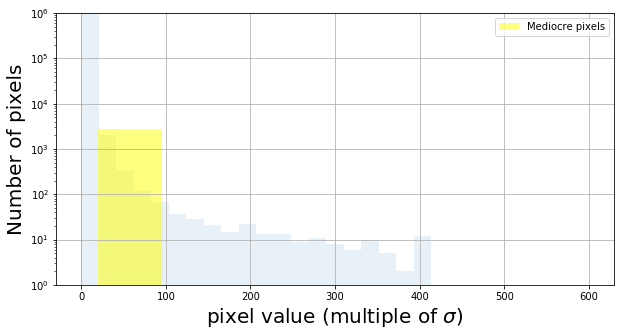

In [25]:
plt.figure(figsize=(10,5))
# plot the details
num, bins, patches = plt.hist(pixel_sigma.flatten(), bins=20, log=True, alpha=0.1)
# now the groupings
num, bins, patches = plt.hist(pixel_sigma.flatten(), bins=sigma_limits, log=True, alpha=0.5)
plt.xlabel('pixel value (multiple of $\sigma$)', size=20)
plt.ylabel('Number of pixels', size=20)
plt.grid()
plt.ylim(1, 10**6)

for i in range(-1, -6, -1):
    foo = patches[i]
    foo.set_alpha(0)
foo = patches[-3]
foo.set_facecolor('yellow')
foo.set_label('Mediocre pixels')
foo.set_alpha(0.5)
plt.legend()

## Locations of super bad pixels

Area of each circle is proportional to the number of standard deviations it is from the mean. 

All pixels with a standard deviation larger than 95 are shown as symbols.

In [26]:
superbad = pixel_sigma > pixel_max_limit
superbad_locs = np.argwhere(superbad)

(2048, 0)

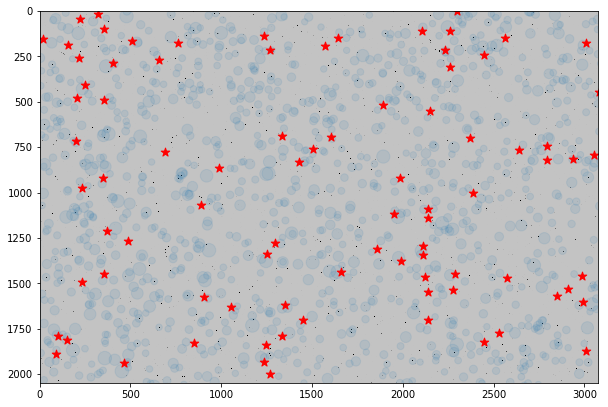

In [27]:
bad_coords = np.argwhere(bad_pixels)
plt.figure(figsize=(10,10))
plt.imshow(longest_exposure, cmap='gray_r',vmin=-3*sigma, vmax=10*sigma)
plt.scatter(bad_coords[:,1], bad_coords[:,0], s=pixel_sigma[bad_pixels]/100*200, alpha=0.1)
plt.scatter(superbad_locs[:, 1], superbad_locs[:, 0], marker='*', s=80, c='r')
plt.xlim(0,3073)
plt.ylim(2048, 0)

## Let's look at linearity

## Graph the "mediocre" pixels

Linear fits are not displayed because it is too cluttered with them. Legend is dropped, also because there are too many pixels to keep track of.

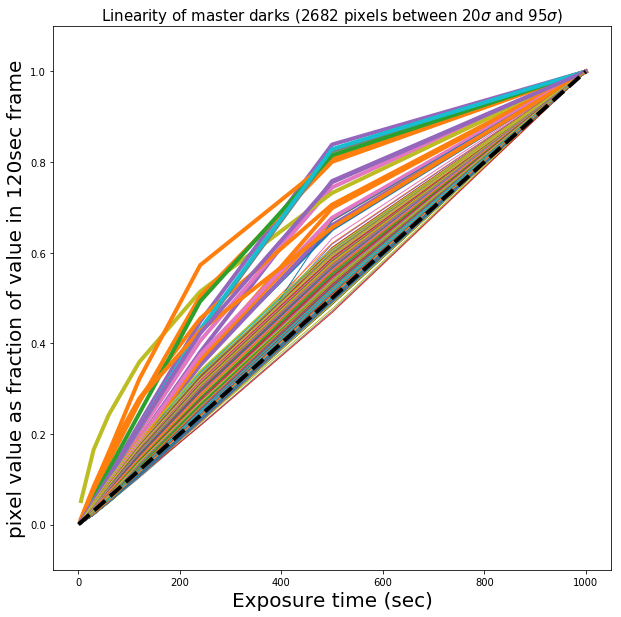

In [28]:
badnesses = plot_linearity(all_darks, bad_locs, exps, pix_min=pixel_min_limit, pix_max=pixel_max_limit, legend=False)

## Almost all of these are linear

There are clearly a few bad ones, but those are a small fraction of the roughly 1,000 pixels in this category.

## Dark current as a function of exposure time

If the data were linear each curve would be a flat line. There is one curve for each bad pixel.

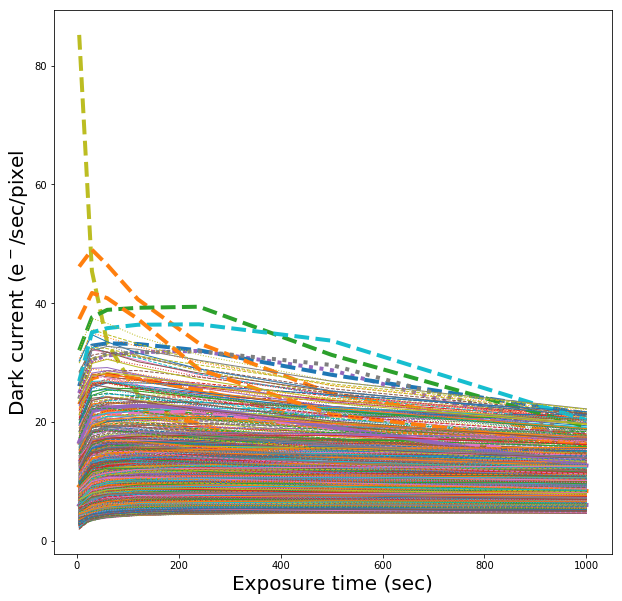

In [29]:
plot_dark_current(all_darks, bad_locs, badnesses, exps, legend=False)

# Summary

This set of pixels also has relatively high dark current, but is mostly correctable.

# Only Very Bad Pixels
Pixels with $\sigma$ values greater than 280.

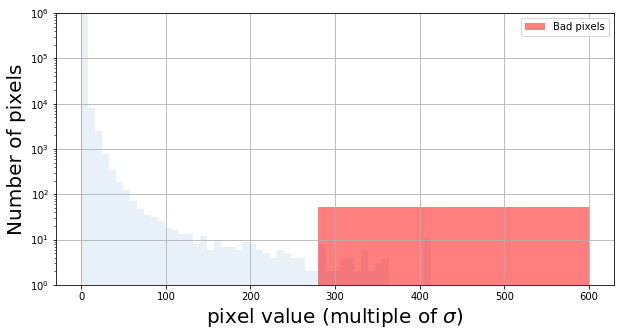

In [30]:
plt.figure(figsize=(10,5))
# plot the details
num, bins, patches = plt.hist(pixel_sigma.flatten(), bins=50, log=True, alpha=0.1)
# now the groupings
num, bins, patches = plt.hist(pixel_sigma.flatten(), bins=sigma_limits, log=True, alpha=0.5)
plt.xlabel('pixel value (multiple of $\sigma$)', size=20)
plt.ylabel('Number of pixels', size=20)
plt.grid()
plt.ylim(1, 10**6)

for i in range(-1, -6, -1):
    foo = patches[i]
    foo.set_alpha(0)
foo = patches[-1]
foo.set_facecolor('red')
foo.set_label('Bad pixels')
foo.set_alpha(0.5)
plt.legend()